In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

#폰트 깨짐 방지지
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
import pandas as pd
import glob

data_dir = r"C:\abusing_data\학습용\학습_병합"
json_files = sorted(glob.glob(data_dir + r"\merged_train_*.json"))

# 여러 개의 파일을 일부만 불러서 전체 카테고리 추정
dfs = []
for f in json_files[:15]:  # 앞에서 15개 파일만 불러오기
    df = pd.read_json(f, encoding='utf-8')
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)
print(df_all['category'].value_counts())

# 카테고리별 clickbait 분포 확인
category_stats = df_all.groupby('category')['clickbait'].value_counts().unstack(fill_value=0)
print(category_stats)



category
사회       49434
세계       44977
경제       42064
IT&과학    40293
정치       39379
연예       36021
생활&문화    31641
Name: count, dtype: int64
clickbait      0      1
category               
IT&과학      20311  19982
경제         21400  20664
사회         22913  26521
생활&문화      14291  17350
세계         23425  21552
연예         18520  17501
정치         19217  20162


In [1]:
#데이터 로딩
import pandas as pd
import glob
data_dir = r"C:\abusing_data\학습용\학습_병합"
json_files = sorted(glob.glob(data_dir + r"\merged_train_*.json"))

df = pd.concat([pd.read_json(f, encoding='utf-8') for f in json_files], ignore_index=True)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
import re

#전처리 함수
def clean_text(text):
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\s+", " ", text)
    text = text.strip()
    return " ".join([w for w in text.split() if w.lower() not in ENGLISH_STOP_WORDS])

#그룹 정의

group_def = {
    "A": ['경제'],
    "B": ['경제', '사회', '연예'],
    "C": ['경제', '사회', '정치', '연예', '세계']
}
unseen_cats = ['IT&과학', '생활&문화']


def get_global_n_equal_total(df, group_def):
    group_mins = []
    for categories in group_def.values():
        per_cat_min = [
            min(
                len(df[(df['category'] == cat) & (df['clickbait'] == 0)]),
                len(df[(df['category'] == cat) & (df['clickbait'] == 1)])
            )
            for cat in categories
        ]
        group_mins.append(min(per_cat_min) * len(categories))  #그룹 총 샘플 수
    return min(group_mins)  #모든 그룹이 감당 가능한 최소값

global_n = get_global_n_equal_total(df, group_def)
print(f"✅ 모든 그룹에 적용할 총 샘플 수: {global_n}")

#공정 샘플링 함수
def sample_equal_total(df, categories, total_n):
    per_cat_n = total_n // len(categories)
    result = []
    for cat in categories:
        df_cat = df[df['category'] == cat]
        df_0 = df_cat[df_cat['clickbait'] == 0]
        df_1 = df_cat[df_cat['clickbait'] == 1]
        if len(df_0) < per_cat_n or len(df_1) < per_cat_n:
            print(f"⚠️ {cat} 샘플 부족: 0({len(df_0)}), 1({len(df_1)})")
            continue
        result.extend([
            df_0.sample(n=per_cat_n, random_state=42),
            df_1.sample(n=per_cat_n, random_state=42)
        ])
    return pd.concat(result).sample(frac=1, random_state=42).reset_index(drop=True)


#학습 + 평가 함수
def train_and_eval_unseen(train_df, val_df, label="모델"):
    train_df['clean_text'] = train_df['text'].apply(clean_text)
    val_df['clean_text'] = val_df['text'].apply(clean_text)

    tfidf = TfidfVectorizer(
        max_features=20000,
        ngram_range=(1, 3),
        min_df=2,
        max_df=0.9,
        sublinear_tf=True
    )

    X_train = tfidf.fit_transform(train_df['clean_text'])
    y_train = train_df['clickbait']
    X_test = tfidf.transform(val_df['clean_text'])
    y_test = val_df['clickbait']

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n📊 [Unseen 평가] {label}")
    print(classification_report(y_test, y_pred, digits=4))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{label} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()


df_group_a = sample_equal_total(df, group_def["A"], total_n=15000)
df_group_b = sample_equal_total(df, group_def["B"], total_n=15000)
df_group_c = sample_equal_total(df, group_def["C"], total_n=15000)


✅ 모든 그룹에 적용할 총 샘플 수: 20664


In [3]:
#검증데이터 로딩
import pandas as pd
import glob 


val_dir = r"C:\abusing_data\검증용\검증_병합"
val_files = sorted(glob.glob(val_dir + r"\merged_val_*.json"))

df_val = pd.concat([pd.read_json(f, encoding='utf-8') for f in val_files], ignore_index=True)


📊 [Unseen 평가] 모델 A
              precision    recall  f1-score   support

           0     0.4781    0.5857    0.5265      8731
           1     0.5148    0.4073    0.4548      9420

    accuracy                         0.4931     18151
   macro avg     0.4964    0.4965    0.4906     18151
weighted avg     0.4971    0.4931    0.4893     18151



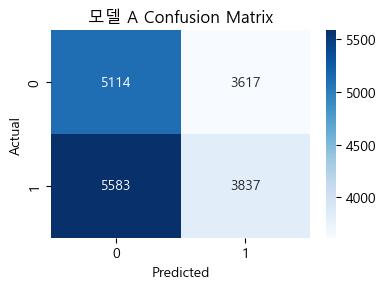


📊 [Unseen 평가] 모델 B
              precision    recall  f1-score   support

           0     0.4917    0.6107    0.5448      8731
           1     0.5349    0.4150    0.4674      9420

    accuracy                         0.5091     18151
   macro avg     0.5133    0.5128    0.5061     18151
weighted avg     0.5141    0.5091    0.5046     18151



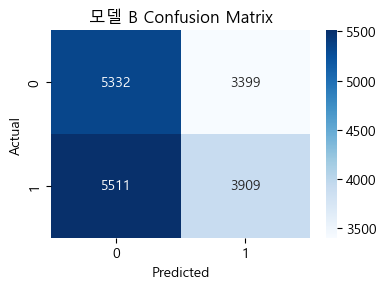


📊 [Unseen 평가] 모델 C
              precision    recall  f1-score   support

           0     0.4923    0.5097    0.5008      8731
           1     0.5302    0.5128    0.5214      9420

    accuracy                         0.5113     18151
   macro avg     0.5112    0.5113    0.5111     18151
weighted avg     0.5120    0.5113    0.5115     18151



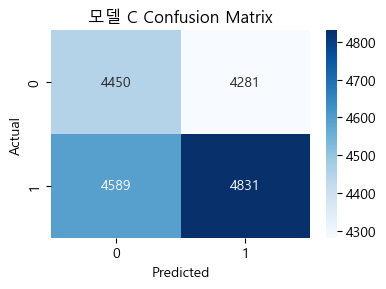

In [ ]:

df_val_unseen = df_val[df_val['category'].isin(unseen_cats)].copy()

train_and_eval_unseen(df_group_a, df_val_unseen, label="모델 A")
train_and_eval_unseen(df_group_b, df_val_unseen, label="모델 B")
train_and_eval_unseen(df_group_c, df_val_unseen, label="모델 C")

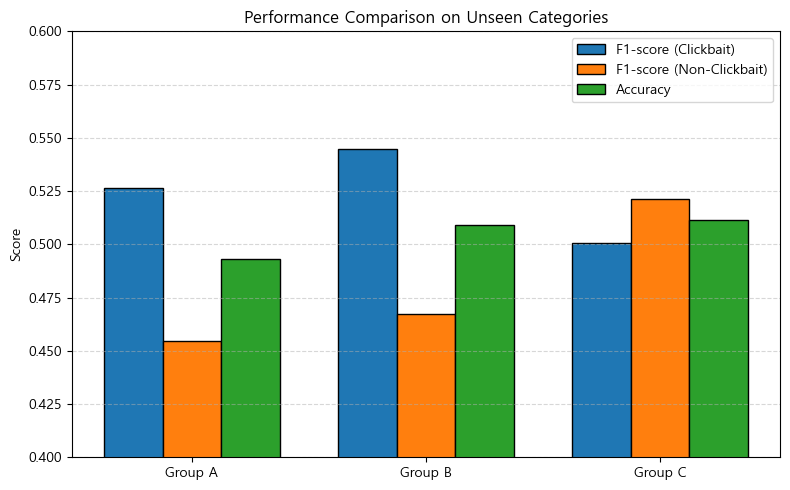

In [6]:
import matplotlib.pyplot as plt
import numpy as np

model_names = ['Group A', 'Group B', 'Group C']
f1_clickbait = [0.5265, 0.5448, 0.5008]   # class 0 (clickbait)
f1_nonclickbait = [0.4548, 0.4674, 0.5214]  # class 1 (non-clickbait)
accuracy = [0.49310, 0.5091, 0.5113]

x = np.arange(len(model_names))
width = 0.25

plt.figure(figsize=(8, 5))
plt.bar(x - width, f1_clickbait, width=width, label='F1-score (Clickbait)', edgecolor='black')
plt.bar(x, f1_nonclickbait, width=width, label='F1-score (Non-Clickbait)', edgecolor='black')
plt.bar(x + width, accuracy, width=width, label='Accuracy', edgecolor='black')

plt.xticks(x, model_names)
plt.ylabel('Score')
plt.ylim(0.4, 0.6)
plt.title('Performance Comparison on Unseen Categories')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()